Here is the random placement code. You should be able to generalize everything! Please let me know if you have any questions!

In [1]:
# import packages and initialize settings

import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import math
import random as r
import scipy.stats

In [2]:
from phangs import PhangsGalaxy
import scipy.stats as ss
from astropy.io import fits
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d



gal = PhangsGalaxy('ngc6300')
#
hdu = fits.open('/Users/josh/projects/misc/ngc6300_12m+7m+tp_co21_150pc_strict_mom0.fits')
# Build map of radius on the sky
radius = gal.radius(header=hdu[0].header).to(u.kpc).value
# Calculate mean in 0.5 kpc bins
mn, center, _ = ss.binned_statistic(radius.ravel(), np.nan_to_num(hdu[0].data).ravel(),bins=np.arange(0,20,0.5), statistic='mean')
# Calculate centres of bins
rmid = (center[0:-1] + center[1:]) * 0.5
# Generate an interpolation function
f = interp1d(rmid, mn, bounds_error=False)
# Evaluate that function for the radius map
azav = f(radius)

In [3]:
# This block of code contains the function to read fits file 
# and deproject galaxy using Adam's deproject.py file


import sys
sys.path.append('/Users/josh/projects/intro/scripts')
from deprojectGalaxy import deproject

def deprojectMap(image, errImage, galRA, galDEC, pa, incl, galDist):
    # convert pixel map to x' & y' and ra & dec
    # image and errImage are the image and noise file pathways
    # galRA, galDEC, pa, incl, galDist are all found within the PHANGS datatabels

    hdulist   = pyfits.open(image)
    intMap    = hdulist[0].data
    hdulist2  = pyfits.open(errImage)
    errMap    = hdulist2[0].data
        
    wcs      = WCS(hdulist[0].header, naxis=2)
    naxis    = wcs._naxis # size of image naxis[0] = x and [1] = y
    grid     = np.indices((naxis[1],naxis[0]))
    ra, dec  = wcs.wcs_pix2world(grid[1],grid[0],0)

    centerCoord = [galRA, galDEC]
    
    #deproject ra and dec to dx and dy
    radius, projang, dx, dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=ra, dec=dec, return_offset=True)
    
    # show galaxy image
    # plt.imshow(map, origin='lower', interpolation='nearest', zorder=1)

    #flatten data structures 
    f_int  = intMap.flatten()
    f_err  = errMap.flatten()
    f_ra   = ra.flatten()
    f_dec  = dec.flatten()    
    f_dx   = dx.flatten()
    f_dy   = dy.flatten()       
    
    #remove nans
    keep  = np.where(np.isfinite(f_int))
    inten = f_int[keep]
    err   = f_err[keep]
    ra    = f_ra[keep]
    dec   = f_dec[keep]
    dx    = f_dx[keep]
    dy    = f_dy[keep]
    
    # calculate SNR
    SNR = []
    for i in range(len(inten)):
        if err[i] == 0.0:
            SNR.append(0.0)
        elif inten[i] < 0.0:
            SNR.append(0.0)           
        else:
            SNR.append(inten[i]/err[i])

    return(inten, err, SNR, ra, dec, dx, dy)
    

In [4]:
# This block of code contains the supporting functions to generate 
# a random distribution, you should not need to call any of these 
# funcitons specifically.

def arraySort(variable, distance):
    # sorts variable and distance list by shortest distance
    # variable, distance: lists holding measurement of variable and distance to that measurement
    pattern = distance.argsort()
    dist = distance[pattern]
    var = variable[pattern]
    return (var, dist)

def findNearest(varArray, value, distArray):
    # sorts variable by distance, returning the closest that has the given value 
    # varArray, distArray: arrays holding measurement of variable and distance to that measurement
    # value: float. 
    var, dist = arraySort(varArray, distArray)
    ind = np.where(var >= value)
    
    if len(dist[ind]) > 0:
        nearestVal  = np.argmin(dist[ind])
        nearestDist = dist[ind][nearestVal] 
        varVal     = var[ind][nearestVal]

    else:
        varVal     = float('nan')
        nearestDist = float('nan')
        
    return(varVal, nearestDist)
    
def printNearest(inten, SNR, dist_kpc, value, SNRcutoff = 3.0):
    # returns distance to the nearest molecular cloud and the intensity value found
    
    #apply SNR cutoff
    intenCut, dist_kpcCut = [],[]
    for i in range(len(inten)):
        if (SNR[i] >= SNRcutoff):
            intenCut.append(inten[i])
            dist_kpcCut.append(dist_kpc[i])
    
    valFound, nearestMC = findNearest(np.array(intenCut), value, np.array(dist_kpcCut))
    
    return(nearestMC, valFound)      

def distanceCalculator(x1, x2, y1, y2, galDist):
    #calculate distance between two points (in kpc)
    #x1, y1 = xprime and yprime, x2, y2 = SN coords, dist = distance to galaxy (kpc)
    d = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    x = galDist * np.tan(d*np.pi/180.0)
    return(x)

def normalize(weightsArray):
    # takes a list of weights and normalizes them
    prob_factor = 1 / sum(weightsArray)
    return [prob_factor * p for p in weightsArray]



In [5]:
# This block of code contains the random function, 
# which performs your random placement experiment using the 
# support functions above.

def random(numTests, weightsArray, dx, dy, ra, dec, galDist):

    # takes number of tests, array of weights, deprojected and 
    #       official coordinates, and distance to galaxy...and returns
    #       list of numTests # of random values, their nearest distance, 
    #       and their randomly generated coordinates
    # numTests: int , number of randomly generated values
    # weightsArray: list of weights 
    # dx&dy:  deprojected coordinates
    # ra&dec: official coordinates 
    # galDist: distance to galaxy in kpc
    val, dist, randX, randY, randRA, randDEC = [],[],[],[],[],[]
    
    for i in range(numTests):
        
        total = sum(weightsArray)
        prob  = weightsArray/total 
        prob  = normalize(prob)
        
        nX = len(dx)  
        indicies = np.arange(nX, dtype=int)
        randInt = np.random.choice(indicies, p=prob)

        rX   = dx[randInt]
        rY   = dy[randInt]
        rRA  = ra[randInt]
        rDEC = dec[randInt]

        distRand = []
        distRand = distanceCalculator(dx, rX, dy, rY, galDist)

        # set sorting cutoff
        intenCutoff = 0
        
        distance, value = printNearest(inten, SNR, distRand, intenCutoff, SNRcutoff=0)
        val.append(value)
        dist.append(distance)
        randX.append(rX)
        randY.append(rY)
        randRA.append(rRA)
        randDEC.append(rDEC)
    return(val, dist, randX, randY, randRA, randDEC)

In [505]:
#PREP COVERAGE MAPS
from astropy.io import fits
import numpy as np
cube = fits.open(fn)
cube[0].data = np.isfinite(cube[0].data).astype(int)
cube.writeto(source+'_2dcoverage.fits')

NameError: name 'fn' is not defined

In [6]:
image = '/Users/josh/projects/misc/ngc6300_m0_mask.fits'
errImage = '/Users/josh/projects/misc/ngc6300_12m+7m+tp_co21_150pc_strict_emom0.fits'
tab_loc = '/Users/josh/projects/misc/'
t = Table.read(tab_loc+'phangs_sample_table_v1p6.fits')

In [7]:
obj = deprojectMap(image, errImage, t[111]['orient_ra'], t[111]['orient_dec'], 
             t[111]['orient_posang'], t[111]['orient_incl'], t[111]['dist'] )

In [8]:
source = 'ngc6300'
res = 150
loc = '/Users/josh/projects/intro/sources'
fp = '/Users/josh/projects/intro/sources/'+str(source)+'/'+str(source)+'_'+str(res)+'pc_cloud_stats.csv'
cat = pd.read_csv(fp)



In [513]:
obj[0]

array([1, 1, 1, ..., 1, 1, 1])

In [9]:
def distcalc(coords, source, res):
    fp = '/Users/josh/projects/intro/sources/'+source+'/'+source+'_12m+7m+tp_co21_'+str(res)+'pc_props.fits.bz2'
    tab = Table.read(fp)
    RA = coords[0]
    DEC = coords[1]
    mean_dist = np.zeros([4,3])
    percentiles = np.zeros([4,15])
    perc = [5,16,50,84,95]
    dist = np.zeros((len(RA),len(RA)))
    distance = np.array(tab['DISTANCE_PC'])
    mindist = np.zeros(len(RA)) #stores distance to nearest neighbor
    mindist2 = np.zeros(len(RA)) #stores distance to 2nd nearest neighbor
    mindist3 = np.zeros(len(RA)) #stores distance to 3rd nearest neighbor
    nn = np.zeros(len(RA)) #stores CloudNum of nearest neighbor
    nn2 = np.zeros(len(RA)) #stores CloudNum of 2nd nearest neighbor
    nn3 = np.zeros(len(RA)) #stores CloudNum of 3rd nearest neighbor
    k = 0
    j = 0
    while k < len(RA):
        for j in range(len(RA)):
            dist[k,j] = np.sqrt(np.square(RA[k] - RA[j]) + np.square(DEC[k] - DEC[j]))
        k+=1
    dist[dist == 0] = np.nan
    k=0
    for k in range(len(RA)):
        ind = np.where(dist[k] == np.nanmin(dist[k])) #index of nearest neighbor
        ind2 = np.where(dist[k] == np.partition(dist[k], 1)[1]) #index of 2nd nearest neighbor
        ind3 = np.where(dist[k] == np.partition(dist[k], 2)[2]) #index of 3rd nearest neighbor
        mindist[k] = np.deg2rad(dist[k,int(ind[0][0])])*distance[0]
        mindist2[k] = np.deg2rad(dist[k,int(ind2[0][0])])*distance[0]
        mindist3[k] = np.deg2rad(dist[k,int(ind3[0][0])])*distance[0]
    return(mindist, mindist2, mindist3)


In [11]:
n = 1e3 #TOTAL NUMBER OF DESIRED RANDOM PLACEMENTS DESIRED
numTests = len(cat['min_dist']) #Number of placements per loop (equal to num of real clouds)
numloop = math.ceil(n/numTests)
inten=obj[0]
SNR = obj[2]
dx = obj[5]
dy = obj[6]
galDist = t[111]['dist']
coords = [[],[]]
rand_first, rand_second, rand_third = [], [], []
df = pd.DataFrame()
for i in range(numloop):
    tests = random(numTests, inten, dx, dy, obj[3], obj[4], galDist)
    coords[0] = tests[4]
    coords[1] = tests[5]
    z = distcalc(coords, source, res)
    rand_first.extend(z[0])
    rand_second.extend(z[1])
    rand_third.extend(z[2])
    #Save / Store each individual simulation run
    df['run_'+str(i)] = z[0]
#pd.to_csv('/Users/josh/projects/intro/rand_results/ngc6300_100k.csv')


In [12]:
#rand_first = z[0]
true_first = cat['min_dist']
true_second = cat['min_dist2nd']
true_third = cat['min_dist3rd']

In [13]:
from scipy.stats import norm

In [14]:
rand_mean = np.mean(rand_first)
rand_std = np.std(rand_first)

true_mean = np.mean(true_first)
true_std = np.std(true_first)

In [15]:
rand_cdf = norm.cdf(rand_first, rand_mean, rand_std)
true_cdf = norm.cdf(true_first, true_mean, true_std)

In [16]:
rand_mean

316.6570037814265

In [17]:
true_mean

176.08935853934608

In [18]:
len(rand_cdf)
len(true_cdf)

259

In [19]:
z = norm.pdf(rand_first, rand_mean, rand_std)

In [20]:
rand_sample = r.sample(rand_first, len(true_first))

In [21]:
z = norm.pdf(rand_sample, rand_mean, rand_std)

In [22]:
y = norm.pdf(true_first, true_mean, true_std)

In [23]:
len(true_first)

259

In [24]:
scipy.stats.kstest(rand_first, true_first)

KstestResult(statistic=0.3079150579150579, pvalue=6.35393173459729e-18)

In [25]:
scipy.stats.kstest(true_first, rand_first)

KstestResult(statistic=0.3079150579150579, pvalue=6.35393173459729e-18)

In [26]:
scipy.stats.anderson(rand_first, dist='norm')

AndersonResult(statistic=43.420725312555305, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [27]:
scipy.stats.anderson(true_first, dist='norm')

AndersonResult(statistic=2.1596456296468887, critical_values=array([0.567, 0.646, 0.775, 0.904, 1.076]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Text(0.5, 0.98, 'GMC Nearest Neighbor Seperation in NGC 6300')

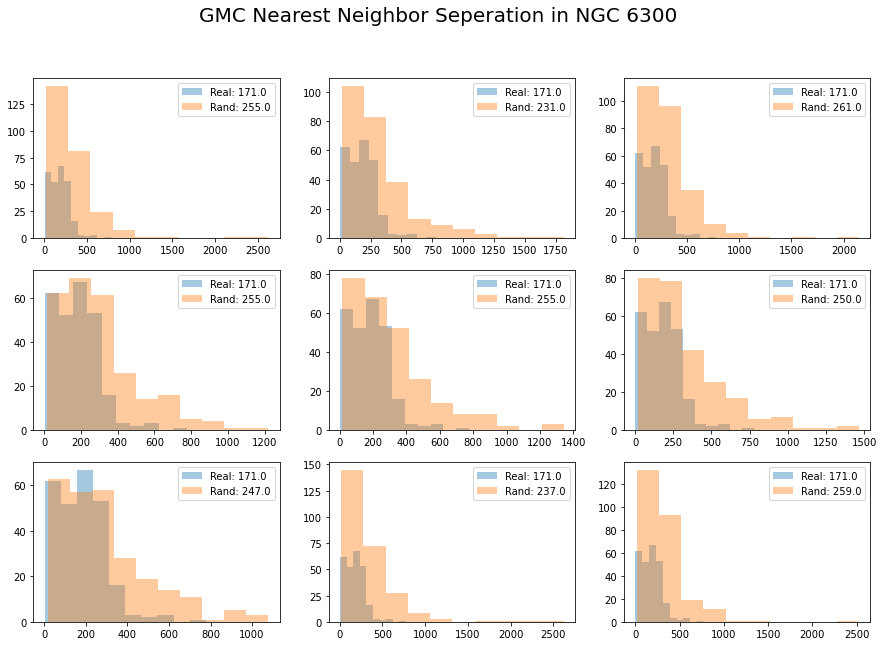

In [28]:
sub_x = 3
sub_y = 3
figsize = (5*sub_x, 10)
fig, ax = plt.subplots(sub_x, sub_y, figsize=figsize)
for i in range(sub_x):
    for j in range(sub_y):
        rand_sample = r.sample(rand_first, len(true_first))
        ax[i,j].hist(true_first, alpha=0.4, label='Real: '+str(np.around(np.median(true_first))))
        ax[i,j].hist(rand_sample, alpha=0.4, label='Rand: '+str(np.around(np.median(rand_sample))))
        ax[i,j].legend()
fig.suptitle('GMC Nearest Neighbor Seperation in NGC 6300', fontsize=20)

In [29]:
len(true_first)

259

In [30]:
###FRACTIONAL DIST
bins = np.linspace(0,1000, 21) #50pc bins

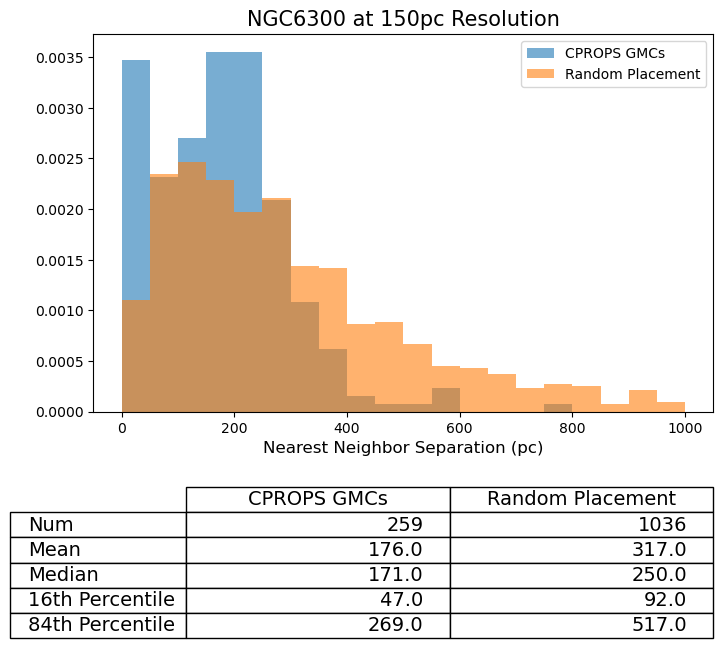

In [31]:
#Table info
num = [len(true_first), len(rand_first)]
mean = np.around([np.mean(true_first), np.mean(rand_first)])
median = np.around([np.median(true_first),np.median(rand_first)])
perc_16 = np.around([np.percentile(true_first,16),np.percentile(rand_first, 16)])
perc_84 = np.around([np.percentile(true_first,84),np.percentile(rand_first, 84)])
rows = ['Num', 'Mean', 'Median', '16th Percentile', '84th Percentile']
columns = ['CPROPS GMCs', 'Random Placement']
cell_text = [num,mean,median,perc_16,perc_84]




plt.figure(figsize=(8,5), dpi = 100)
plt.hist(true_first, bins=bins, density=True, histtype='stepfilled', alpha = 0.6, label='CPROPS GMCs')
plt.hist(rand_first, bins=bins, density=True, histtype='stepfilled', alpha=0.6, label='Random Placement')
plt.legend()
plt.xlabel('Nearest Neighbor Separation (pc)', fontsize=12)
table = plt.table(cellText=cell_text, rowLabels=rows, colLabels=columns, loc='bottom left', bbox=[0.15, -0.6, 0.85, 0.4])
plt.title('NGC6300 at 150pc Resolution', fontsize=15)
table.set_fontsize(14)
plt.savefig('/Users/josh/projects/phangs_first_year_paper/fig/ngc6300_100k_rand_hist.pdf', bbox_inches="tight", pad_inches=0.25)

In [536]:
len(rand_first)

100233

In [32]:
true = np.histogram(true_first, bins=bins, normed=True)
rand = np.histogram(rand_first, bins=bins, normed=True)

<ipython-input-32-39fe4c349c8b>:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  true = np.histogram(true_first, bins=bins, normed=True)
<ipython-input-32-39fe4c349c8b>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  rand = np.histogram(rand_first, bins=bins, normed=True)


In [33]:
excess_prob = true[0]/rand[0]
excess_prob
len(excess_prob)
bins
#plt.plot(excess_prob, bins)

array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000.])

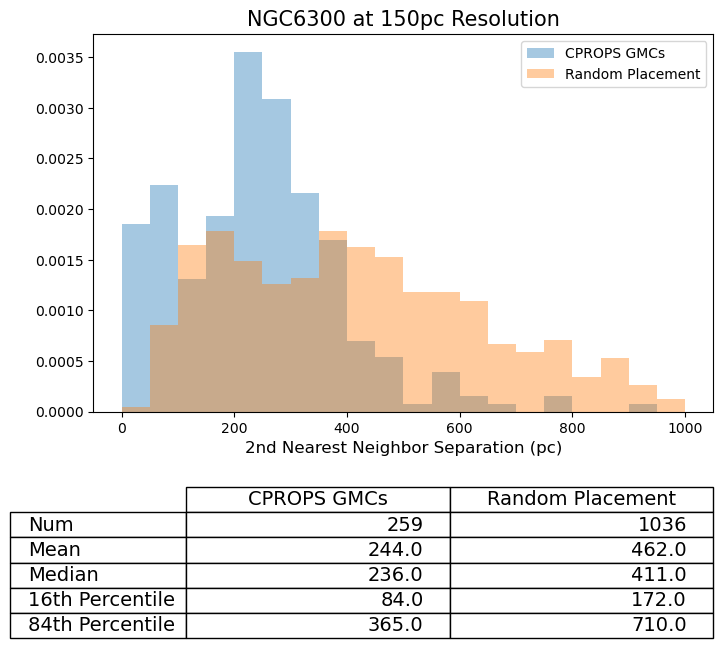

In [34]:
#Table info
num = [len(true_second), len(rand_second)]
mean = np.around([np.mean(true_second), np.mean(rand_second)])
median = np.around([np.median(true_second),np.median(rand_second)])
perc_16 = np.around([np.percentile(true_second,16),np.percentile(rand_second, 16)])
perc_84 = np.around([np.percentile(true_second,84),np.percentile(rand_second, 84)])
rows = ['Num', 'Mean', 'Median', '16th Percentile', '84th Percentile']
columns = ['CPROPS GMCs', 'Random Placement']
cell_text = [num,mean,median,perc_16,perc_84]




plt.figure(figsize=(8,5), dpi = 100)
plt.hist(true_second, bins=bins, density=True, alpha = 0.4, label='CPROPS GMCs')
plt.hist(rand_second, bins=bins, density=True, alpha=0.4, label='Random Placement')
plt.legend()
plt.xlabel('2nd Nearest Neighbor Separation (pc)', fontsize=12)
table = plt.table(cellText=cell_text, rowLabels=rows, colLabels=columns, loc='bottom left', bbox=[0.15, -0.6, 0.85, 0.4])
plt.title('NGC6300 at 150pc Resolution', fontsize=15)
table.set_fontsize(14)
#plt.savefig('/Users/josh/projects/phangs_first_year_paper/fig/ngc6300_10k_rand_hist.pdf', bbox_inches="tight", pad_inches=0.25)

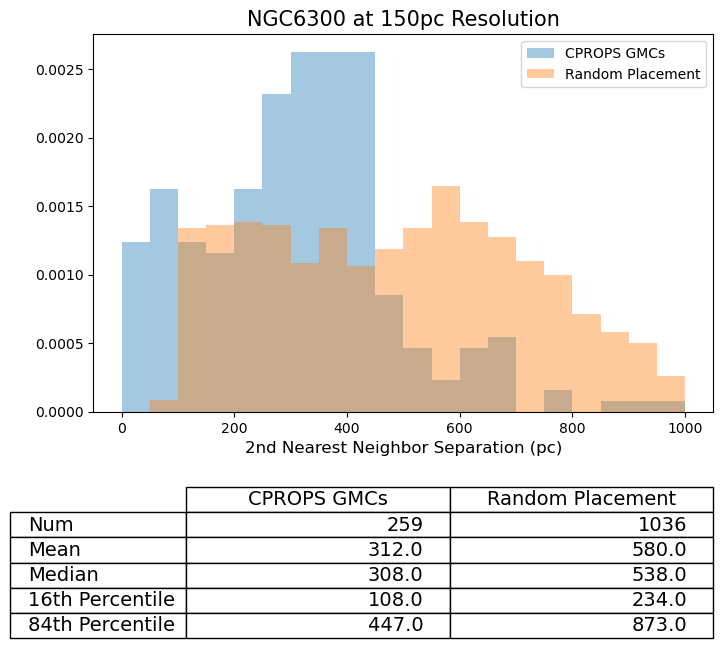

In [35]:
#Table info
num = [len(true_second), len(rand_second)]
mean = np.around([np.mean(true_third), np.mean(rand_third)])
median = np.around([np.median(true_third),np.median(rand_third)])
perc_16 = np.around([np.percentile(true_third,16),np.percentile(rand_third, 16)])
perc_84 = np.around([np.percentile(true_third,84),np.percentile(rand_third, 84)])
rows = ['Num', 'Mean', 'Median', '16th Percentile', '84th Percentile']
columns = ['CPROPS GMCs', 'Random Placement']
cell_text = [num,mean,median,perc_16,perc_84]




plt.figure(figsize=(8,5), dpi = 100)
plt.hist(true_third, bins=bins, density=True, alpha = 0.4, label='CPROPS GMCs')
plt.hist(rand_third, bins=bins, density=True, alpha=0.4, label='Random Placement')
plt.legend()
plt.xlabel('2nd Nearest Neighbor Separation (pc)', fontsize=12)
table = plt.table(cellText=cell_text, rowLabels=rows, colLabels=columns, loc='bottom left', bbox=[0.15, -0.6, 0.85, 0.4])
plt.title('NGC6300 at 150pc Resolution', fontsize=15)
table.set_fontsize(14)

In [36]:
true[0]

array([3.47490347e-03, 2.31660232e-03, 2.70270270e-03, 3.55212355e-03,
       3.55212355e-03, 2.08494208e-03, 1.08108108e-03, 6.17760618e-04,
       1.54440154e-04, 7.72200772e-05, 7.72200772e-05, 2.31660232e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.72200772e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

(array([20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000.]),
 <a list of 20 Patch objects>)

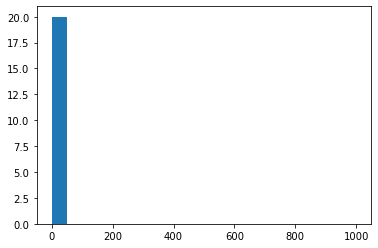

In [37]:
plt.hist(true[0]*50, bins=bins)

In [38]:
excess_probs = (true[0] * np.diff(true[1])) / (rand[0] * np.diff(rand[1]))
excess_probs

array([3.14602868, 0.98698939, 1.09621622, 1.55252297, 1.80092664,
       0.98791181, 0.75083302, 0.43500644, 0.17795718, 0.08700129,
       0.11514876, 0.51065973, 0.        , 0.        , 0.        ,
       0.27964699, 0.        , 0.        , 0.        , 0.        ])

(0.01, 100)

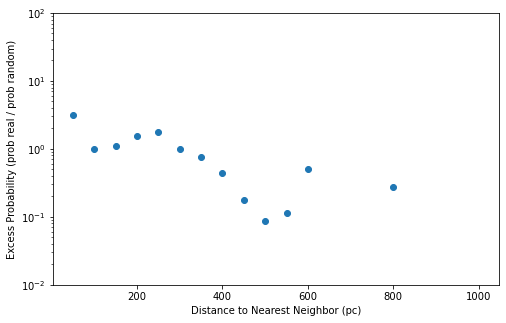

In [39]:
plt.figure(figsize=(8,5))
plt.scatter(bins[1:], excess_prob)
plt.xlabel('Distance to Nearest Neighbor (pc)')
plt.ylabel('Excess Probability (prob real / prob random)')
plt.yscale('log')
plt.ylim((0.01,100))

<BarContainer object of 20 artists>

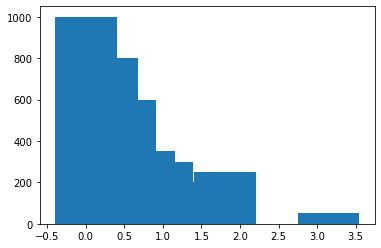

In [40]:
plt.bar(excess_probs, bins[1:])

In [589]:
bins

array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000.])